<h1>credit card fraud detection</h1>

dữ liệu sử dụng: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

quy trình:
1.  tải và tiền xử lý bộ dữ liệu "Credit Card Fraud Detection" từ kaggle.
2.  định nghĩa kiến trúc autoencoder
3.  chỉ huấn luyện mô hình autoencoder trên các giao dịch bình thường.
4.  tính toán sai số tái tạo (reconstruction error) cho tất cả giao dịch.
5.  xác định một ngưỡng để phân loại giao dịch là bình thường hay gian lận.
6.  đánh giá hiệu suất của mô hình.

### tải dữ liệu

In [4]:
# tải dữ liệu
!curl -L -o creditcardfraud.zip\
  https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud

# giải nén
!unzip creditcardfraud.zip -d data/

# giải phóng file creditcardfraud.zip
!rm creditcardfraud.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 65.9M  100 65.9M    0     0  9224k      0  0:00:07  0:00:07 --:--:-- 11.3M
Archive:  creditcardfraud.zip
  inflating: data/creditcard.csv     


### nhập các thư viện cần thiết

In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
from typing import Tuple
from pprint import pprint

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 150
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

### đọc dữ liệu

In [2]:
data_path = "./data/creditcard.csv"
df = pd.read_csv(data_path)

### khám phá dữ liệu

In [3]:
print("5 dòng dữ liệu đầu tiên:")
df.head()

5 dòng dữ liệu đầu tiên:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print("Thông tin tổng quan về bộ dữ liệu:")
df.info()

Thông tin tổng quan về bộ dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     28480

> **Nhận xét:**
> - Bộ dữ liệu có 284,807 dòng và 31 cột.
> - **Không có giá trị thiếu (null/NaN)** trong bất kỳ cột nào
> - Các cột `V1` đến `V28` là kết quả của phép biến đổi PCA
> - `Time` và `Amount` là các biến gốc. `Class` là biến mục tiêu của chúng ta.

Kiểm tra sự phân bổ của các lớp (0: Bình thường, 1: Gian lận):
Class
0    284315
1       492
Name: count, dtype: int64

Tỷ lệ giao dịch gian lận: 0.1727%


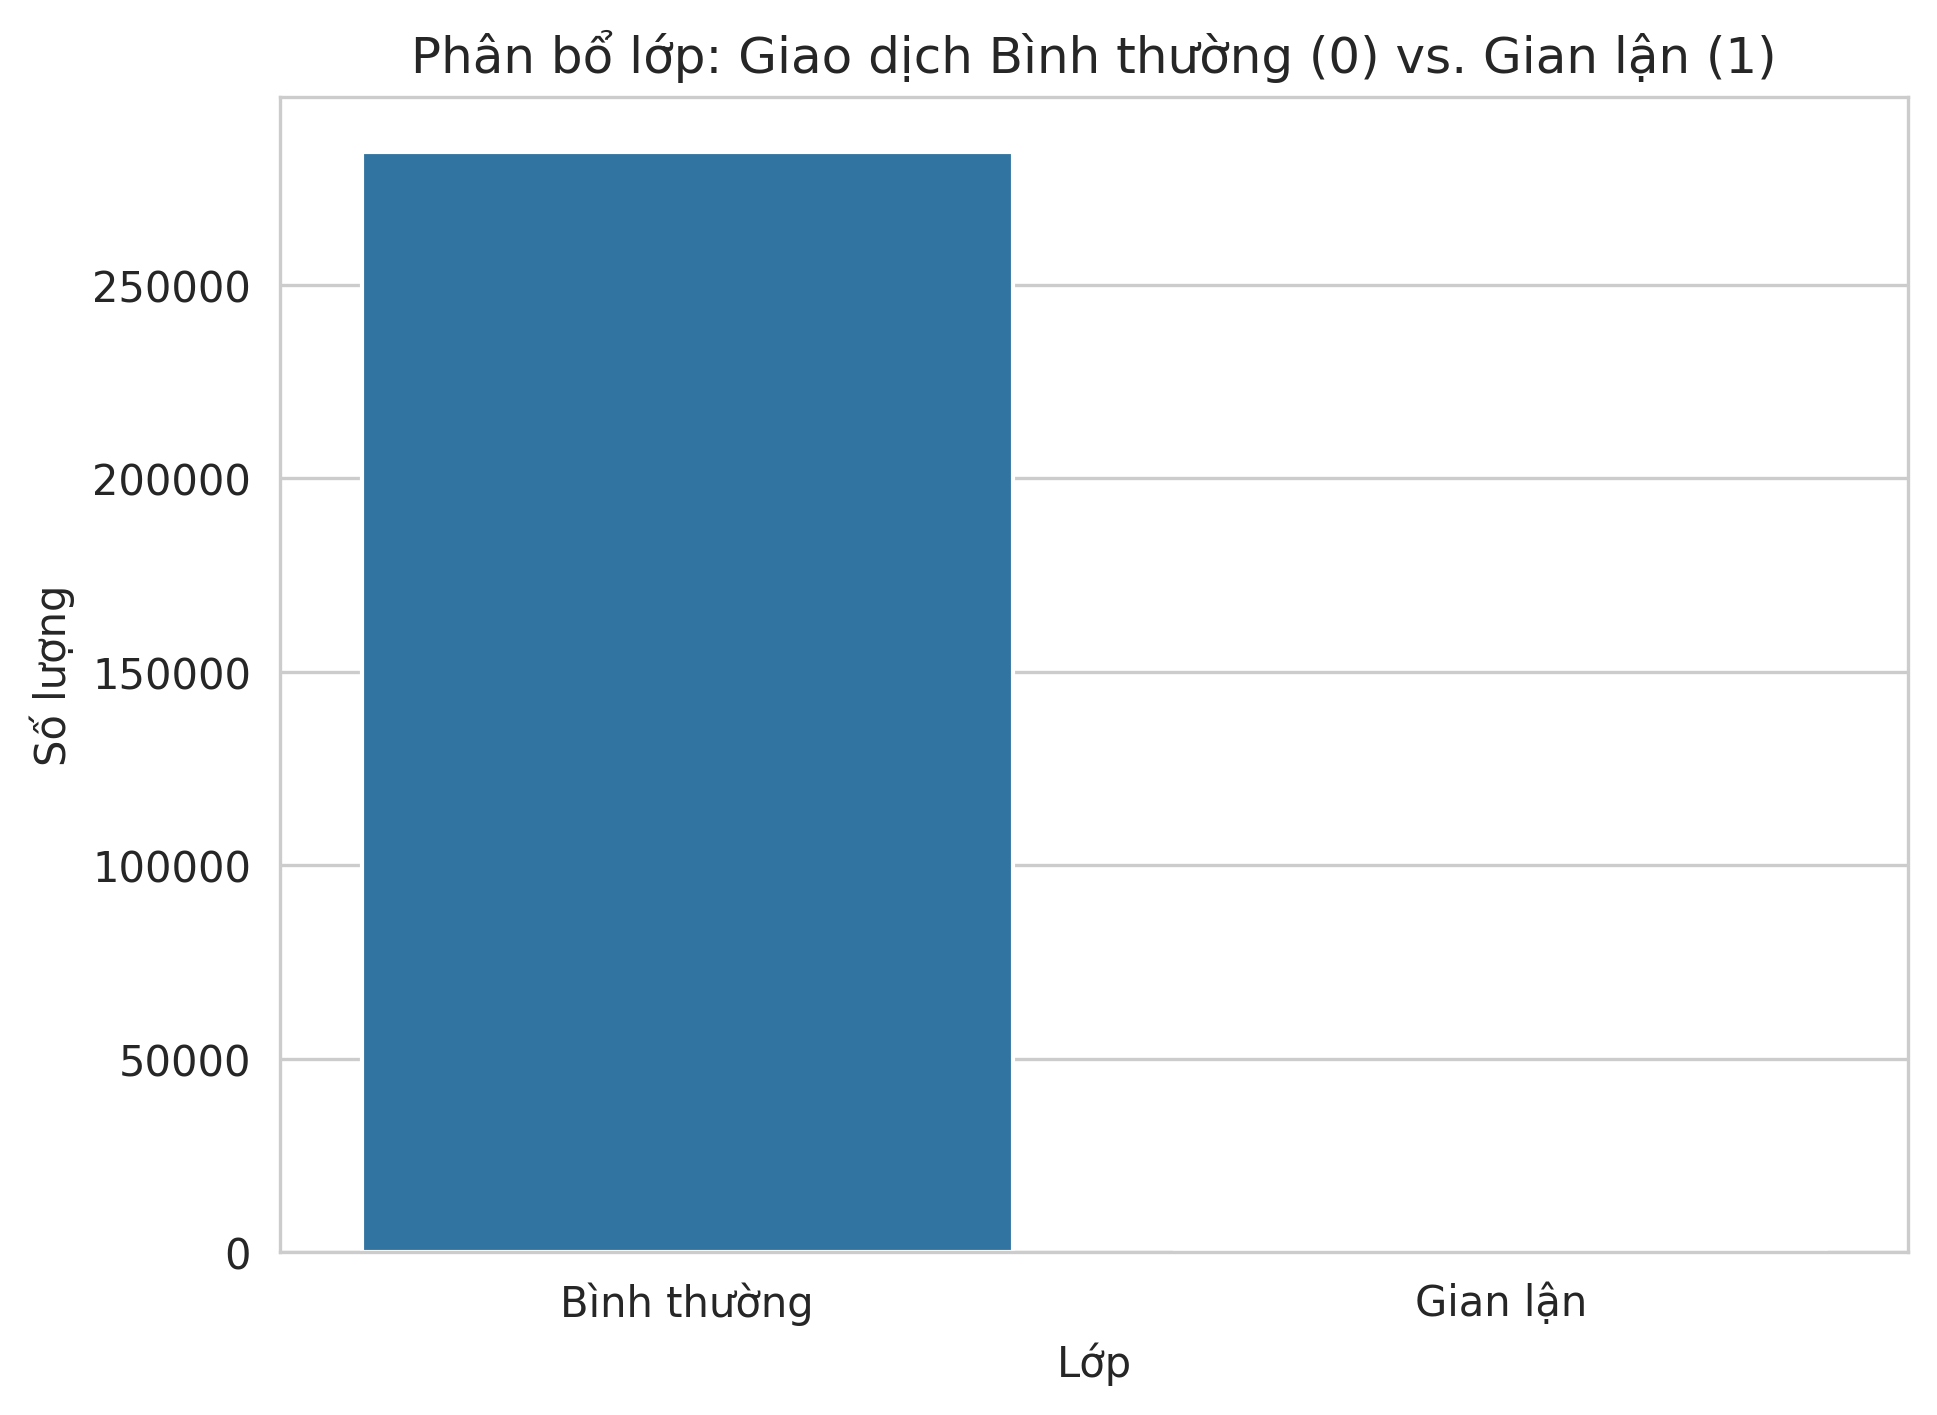

In [5]:
print("Kiểm tra sự phân bổ của các lớp (0: Bình thường, 1: Gian lận):")
class_counts = df['Class'].value_counts()
print(class_counts)

# tính toán tỷ lệ
fraud_percentage = (class_counts[1] / class_counts.sum()) * 100
print(f"\nTỷ lệ giao dịch gian lận: {fraud_percentage:.4f}%")

# trực quan hóa
plt.figure(figsize=(7, 5))
sns.countplot(x='Class', data=df)
plt.title('Phân bổ lớp: Giao dịch Bình thường (0) vs. Gian lận (1)')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.xticks([0, 1], ['Bình thường', 'Gian lận'])
plt.show()

> **Nhận xét:**
> - **Dữ liệu cực kỳ mất cân bằng (Extremely Imbalanced):** Chỉ có 492 giao dịch gian lận (0.1727%) trong tổng số hơn 284,000 giao dịch.
> - **Ý nghĩa:** Đây là thách thức lớn nhất của bài toán. Một mô hình ngây thơ nếu luôn dự đoán "Bình thường" (0) sẽ đạt độ chính xác (accuracy) > 99.8%, nhưng lại hoàn toàn vô dụng vì không phát hiện được bất kỳ trường hợp gian lận nào.
> - **Hệ quả:** Chúng ta không thể sử dụng **Accuracy** làm thước đo chính. Thay vào đó, phải tập trung vào các thước đo như **Precision, Recall, F1-score, và AUC-ROC / AUC-PR (Precision-Recall Curve)**. Đặc biệt, **Recall** (tỷ lệ phát hiện đúng các ca gian lận) thường được ưu tiên trong bài toán này.


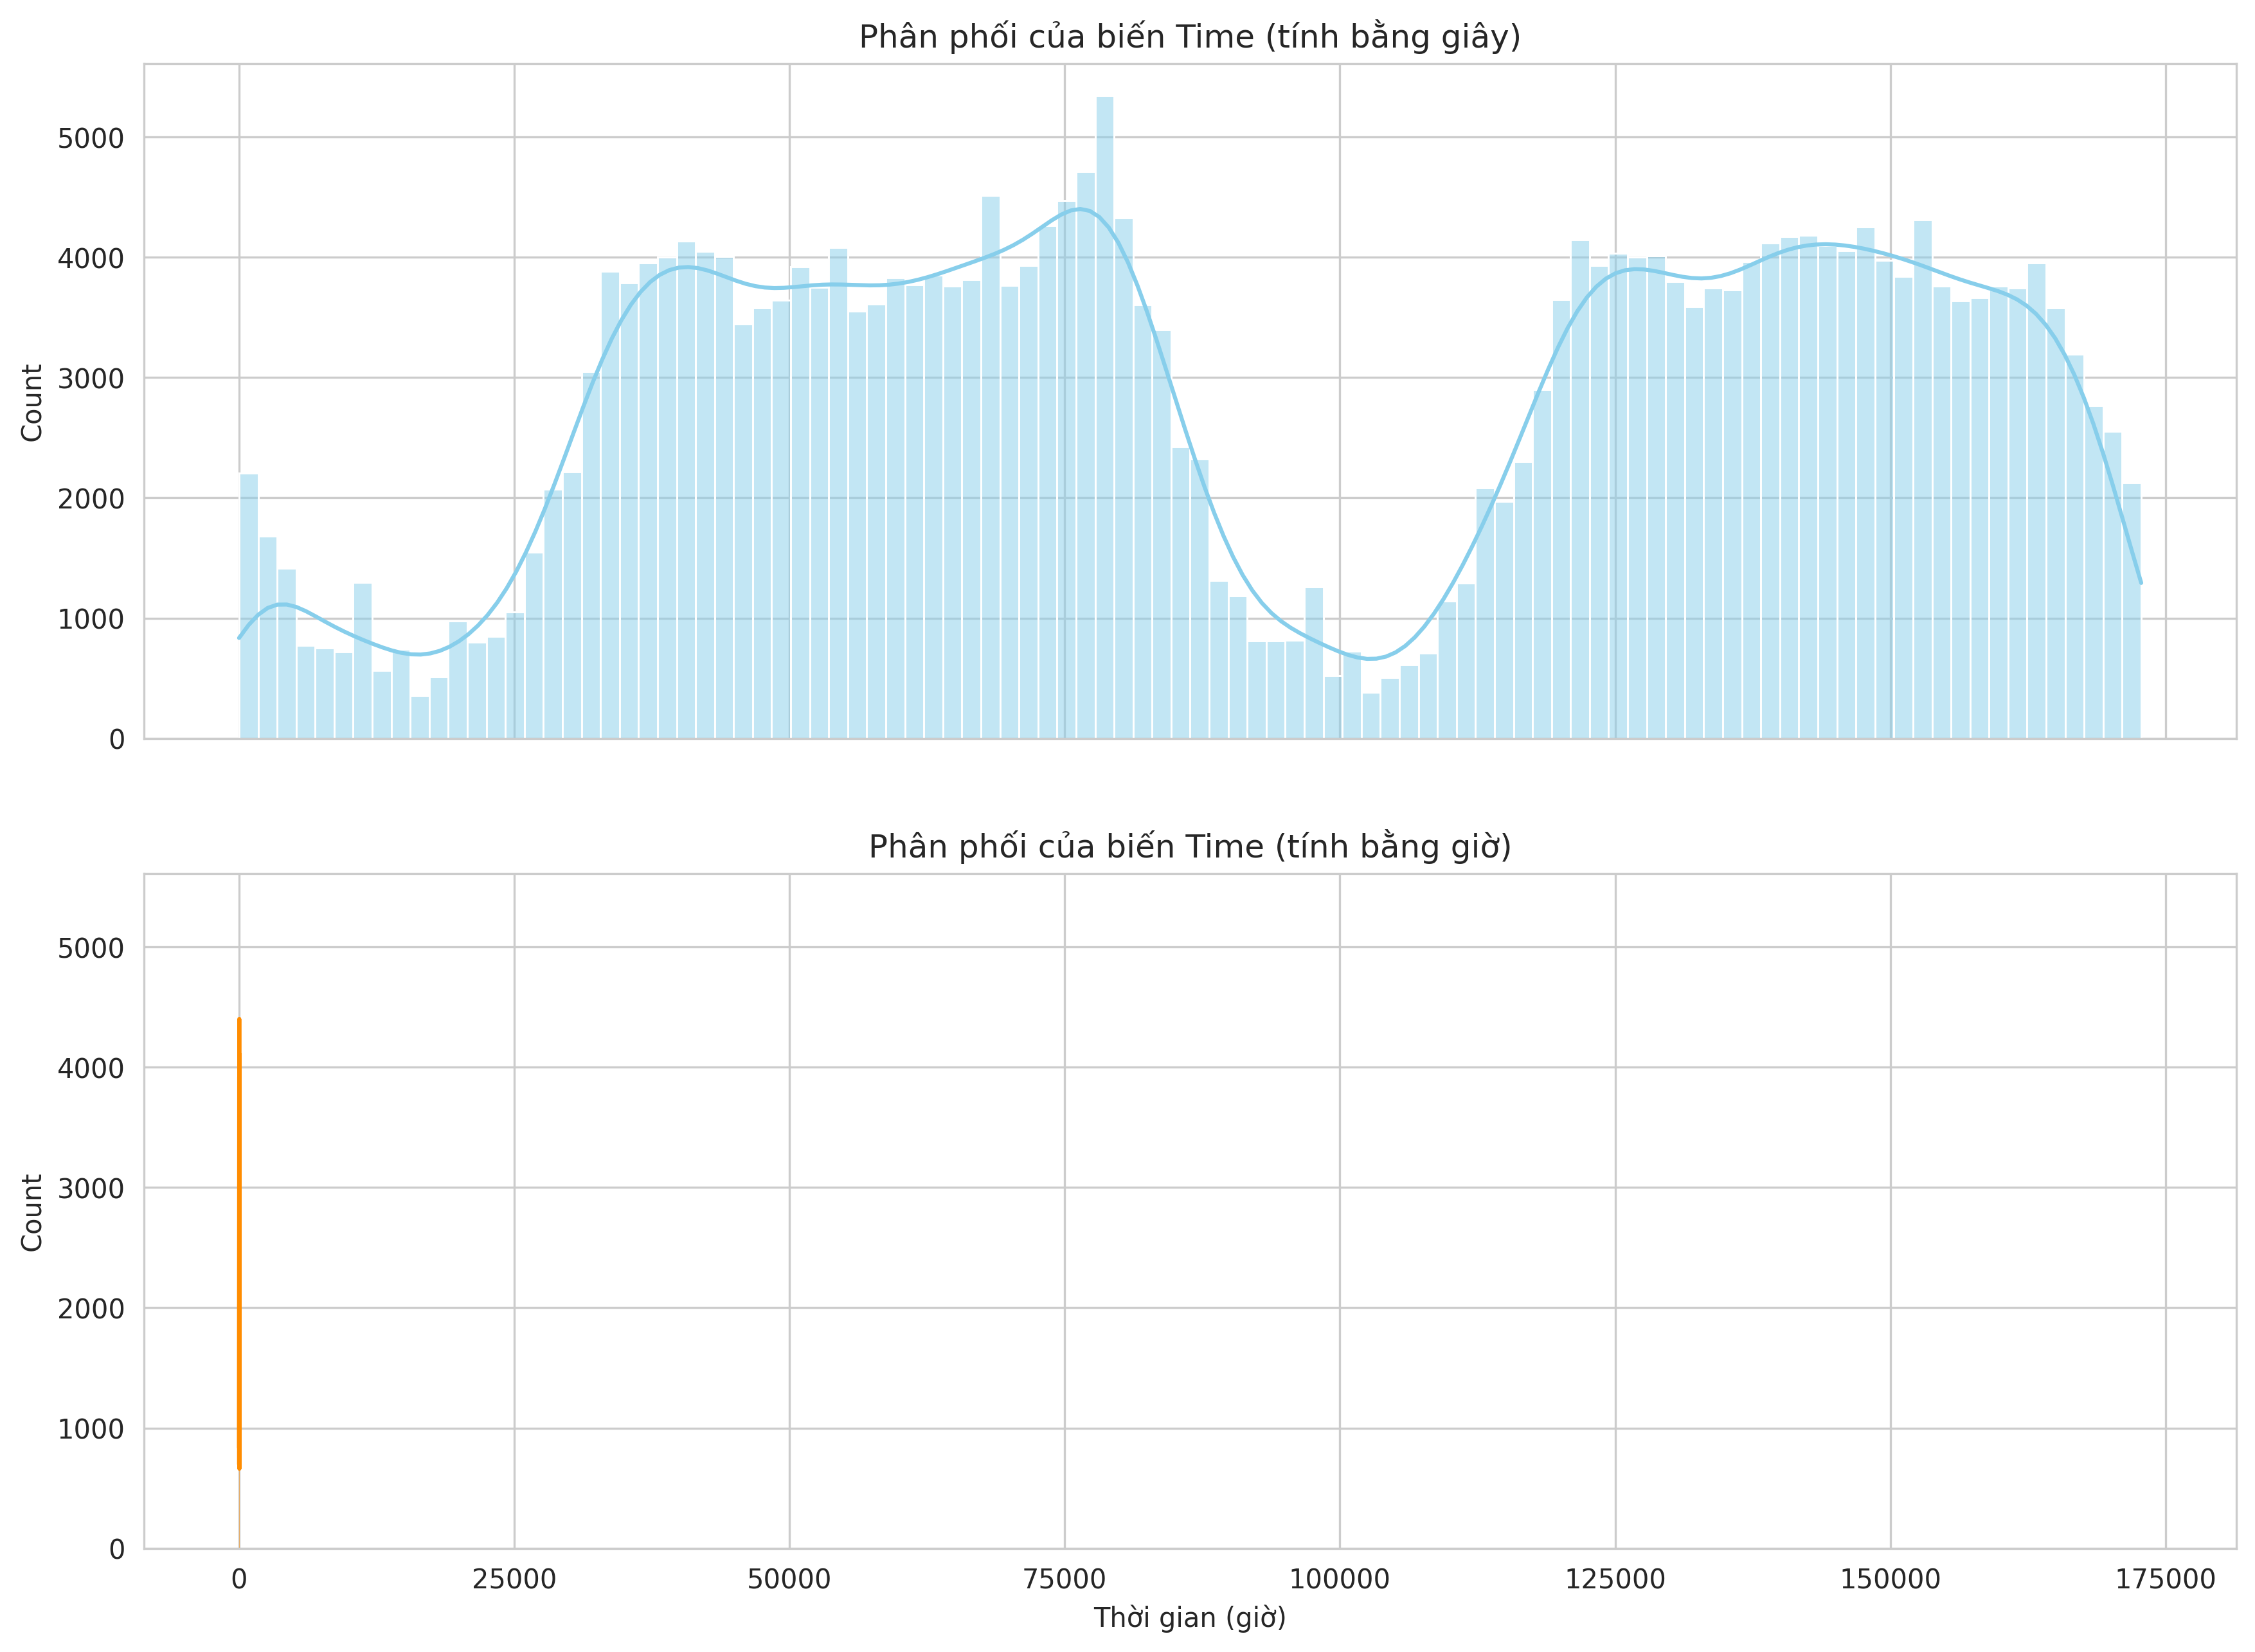

In [6]:
# phân tích biến 'Time'
# biến 'Time' cho biết số giây trôi qua giữa giao dịch này và giao dịch đầu tiên trong bộ dữ liệu.

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

sns.histplot(df['Time'], bins=100, ax=ax1, color='skyblue', kde=True)
ax1.set_title('Phân phối của biến Time (tính bằng giây)')

sns.histplot(df['Time'] / 3600, bins=100, ax=ax2, color='darkorange', kde=True) # Đổi sang giờ
ax2.set_title('Phân phối của biến Time (tính bằng giờ)')
ax2.set_xlabel('Thời gian (giờ)')
plt.show()

> **Nhận xét:**
> - Phân phối của 'Time' có dạng hai đỉnh (bimodal), cho thấy dữ liệu được thu thập trong khoảng 2 ngày (mỗi ngày 24 giờ, tổng cộng khoảng 48 giờ).
> - Các "thung lũng" trong biểu đồ có thể tương ứng với ban đêm, khi số lượng giao dịch giảm xuống.
> - **Ý nghĩa:** Biến 'Time' có thể chứa thông tin về thời điểm trong ngày. Việc biến đổi nó (ví dụ: lấy số giờ trong ngày `Time % (24*3600)`) có thể tạo ra một đặc trưng hữu ích hơn là dùng số giây tuyệt đối.


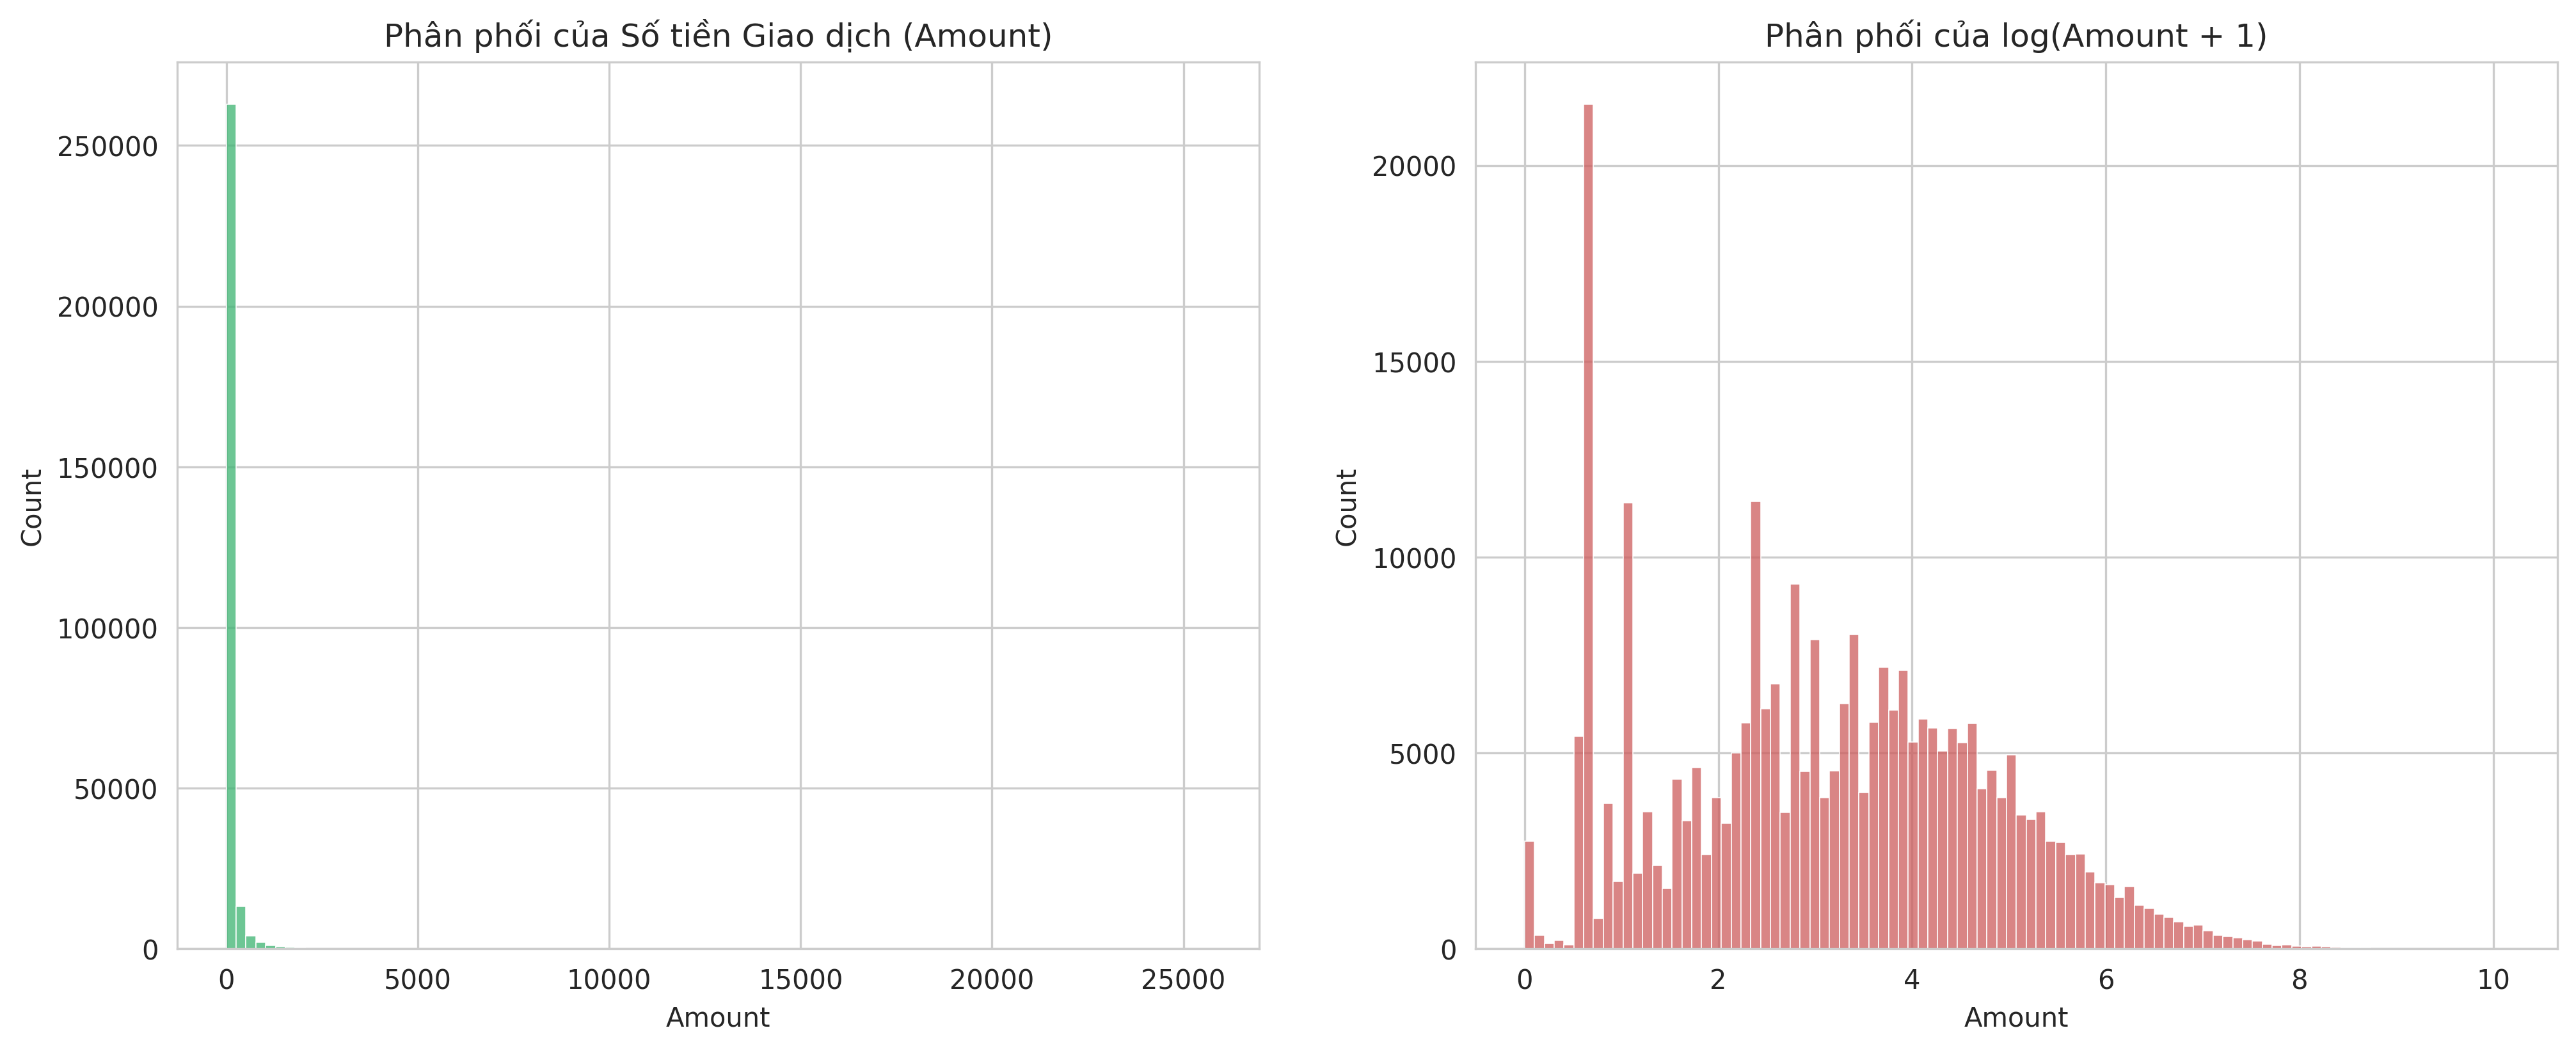


--- So sánh 'Amount' giữa các lớp ---


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87


In [7]:
# phân tích biến 'Amount'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(df['Amount'], bins=100, ax=ax1, color='mediumseagreen')
ax1.set_title('Phân phối của Số tiền Giao dịch (Amount)')

# Sử dụng thang đo log để xử lý độ lệch lớn
sns.histplot(np.log1p(df['Amount']), bins=100, ax=ax2, color='indianred')
ax2.set_title('Phân phối của log(Amount + 1)')
plt.show()

print("\n--- So sánh 'Amount' giữa các lớp ---")
df.groupby('Class')['Amount'].describe()

> **Nhận xét:**
> - Phân phối của 'Amount' bị **lệch phải rất mạnh (highly right-skewed)**. Hầu hết các giao dịch có giá trị nhỏ.
> - Khi xem thống kê, ta thấy số tiền giao dịch trung bình của các ca gian lận (122.21) cao hơn so với các ca bình thường (88.29). Tuy nhiên, độ lệch chuẩn cũng rất cao.
> - **Ý nghĩa:** Biến 'Amount' rất khác nhau về thang đo so với các biến PCA (V1-V28). Do đó, việc **chuẩn hóa (scaling)** nó (ví dụ: dùng `StandardScaler` hoặc `RobustScaler`) là **bắt buộc** trước khi đưa vào các mô hình như Autoencoder, SVM, hay Logistic Regression.


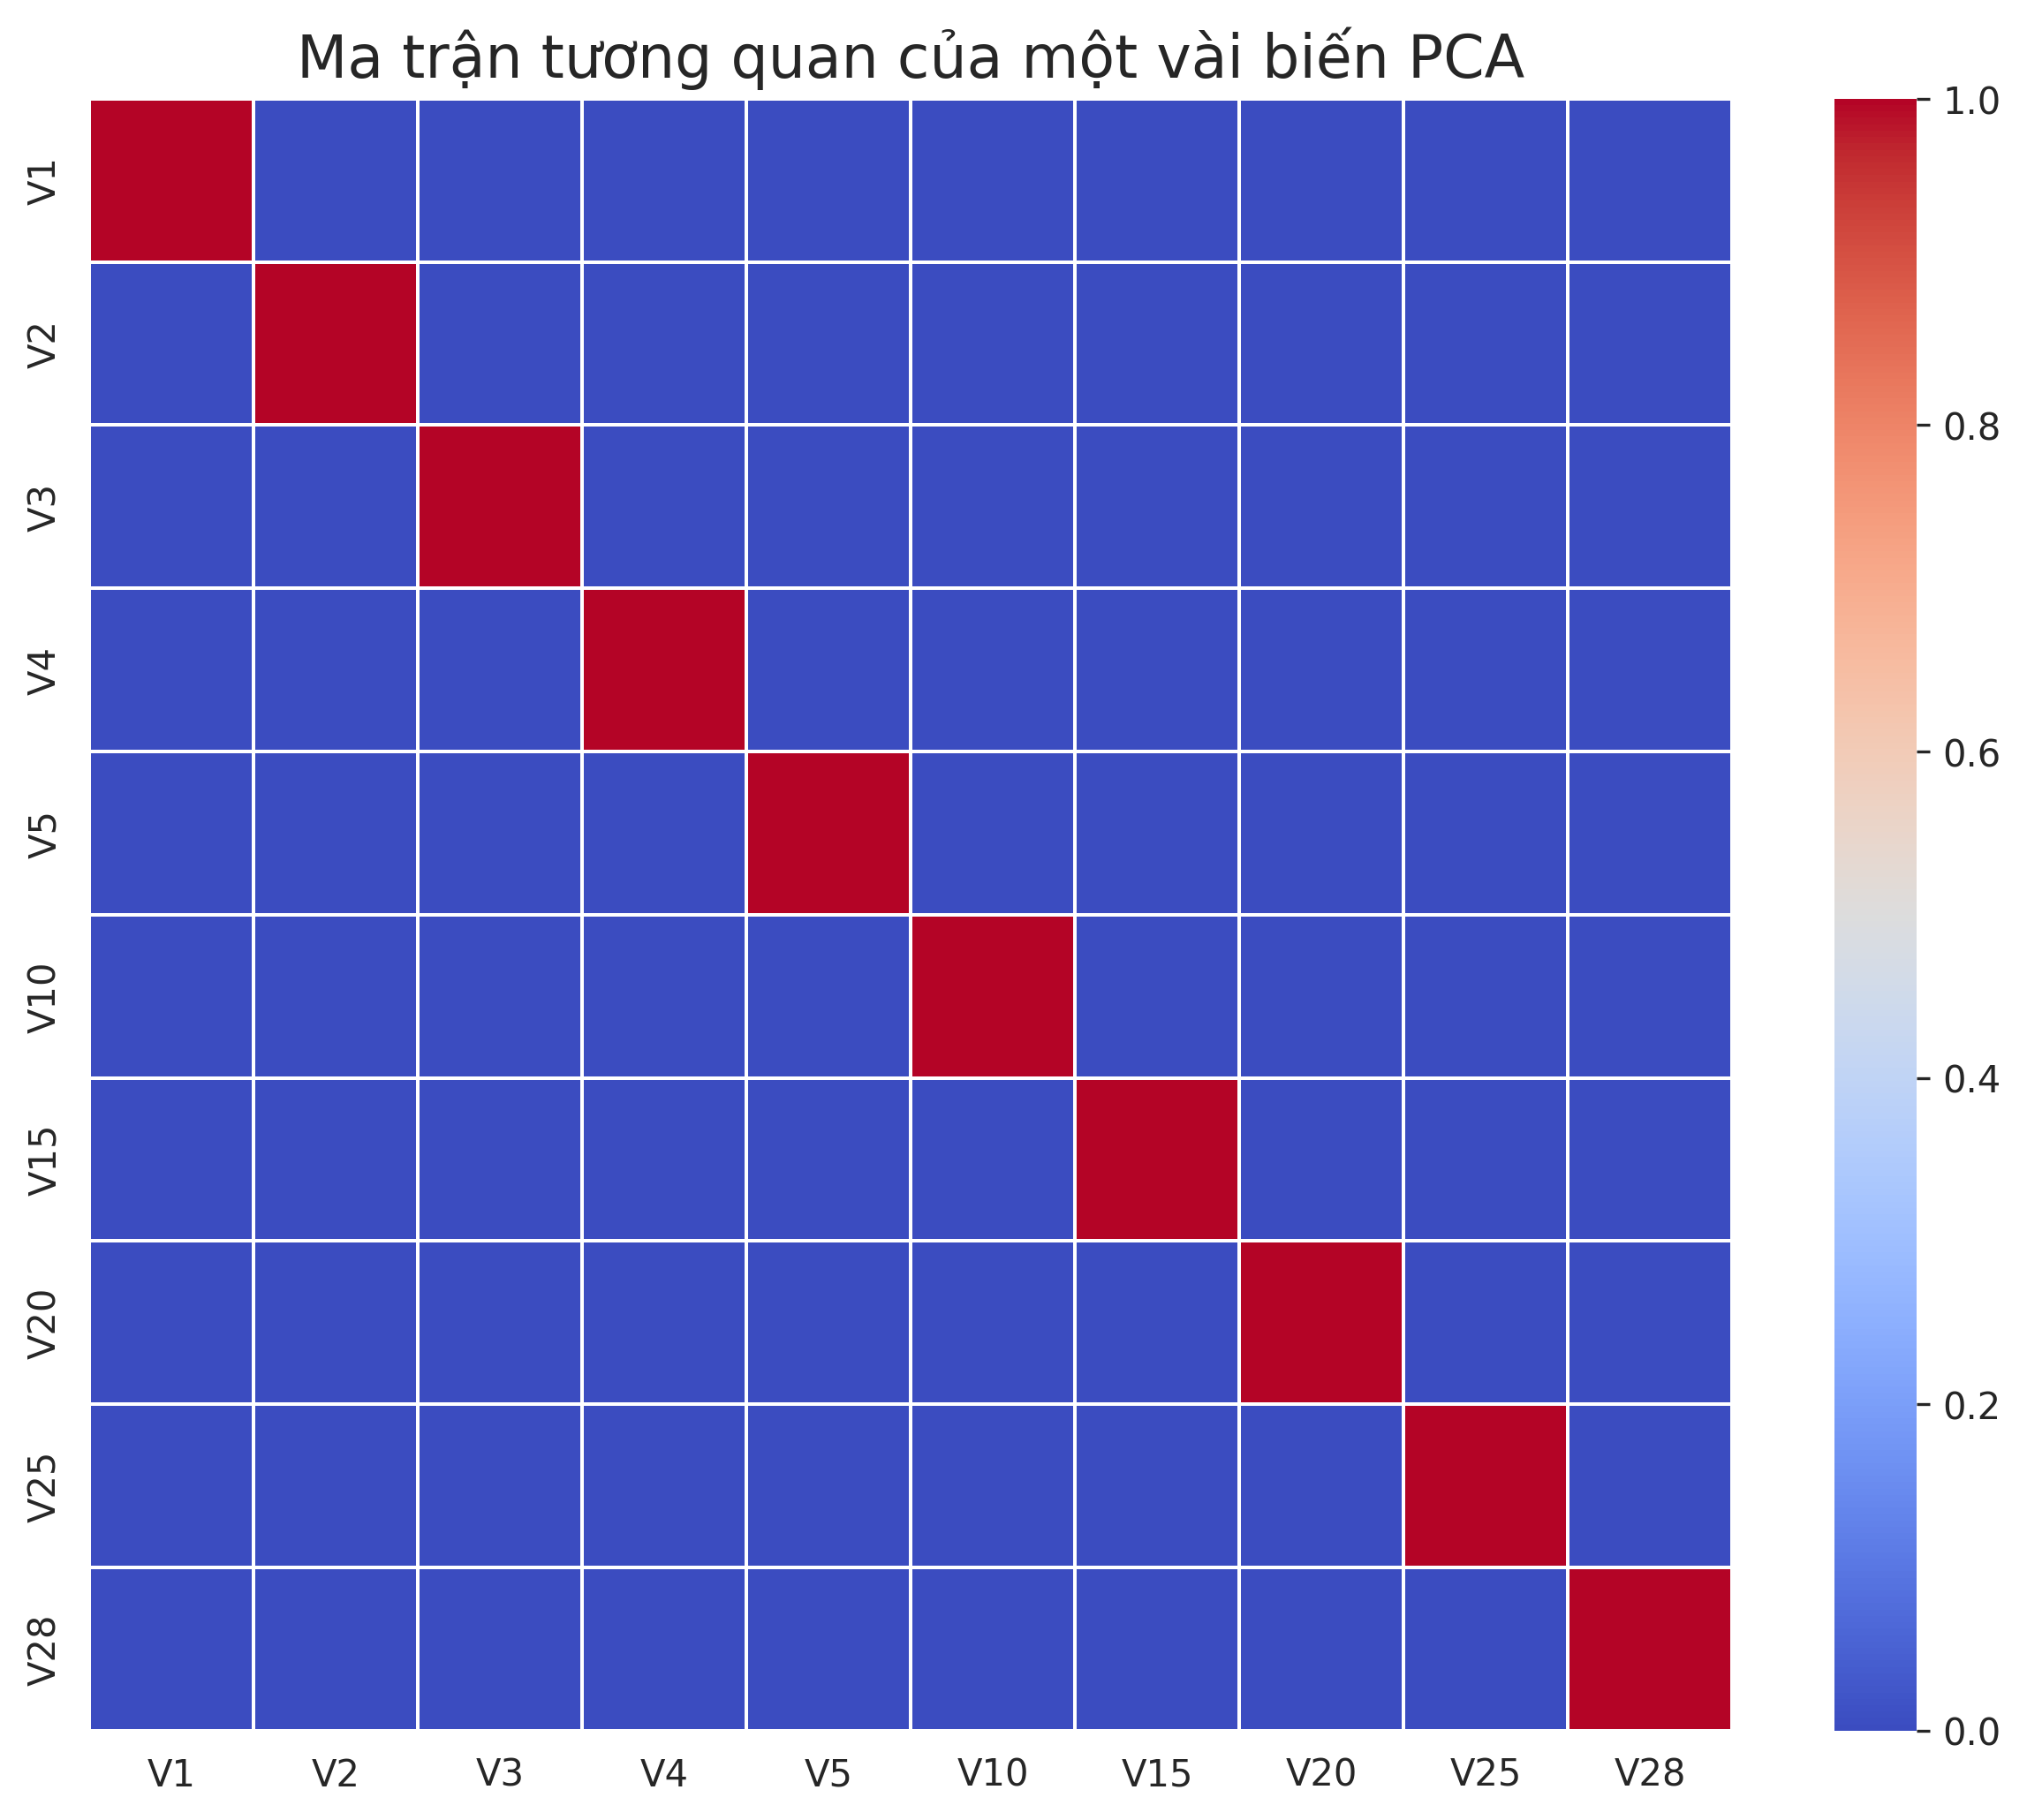

In [8]:
# phân tích các biến PCA (V1-V28)

# xem xét mối tương quan
# do các biến V1-V28 là kết quả của PCA, chúng ta kỳ vọng chúng sẽ không có tương quan với nhau.

# chọn một vài biến để vẽ ma trận tương quan
pca_features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V10', 'V15', 'V20', 'V25', 'V28']
correlation_matrix = df[pca_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Ma trận tương quan của một vài biến PCA', fontsize=16)
plt.show()


> **Nhận xét:**
> - Như dự đoán, ma trận tương quan cho thấy các biến PCA gần như **không có tương quan tuyến tính** với nhau (các giá trị ngoài đường chéo đều gần 0).
> - **Ý nghĩa:** Điều này rất tốt cho các mô hình hồi quy tuyến tính vì nó tránh được hiện tượng đa cộng tuyến (multicollinearity). Chúng ta có thể sử dụng các biến này trực tiếp mà không cần thêm bước lựa chọn đặc trưng để loại bỏ tương quan.


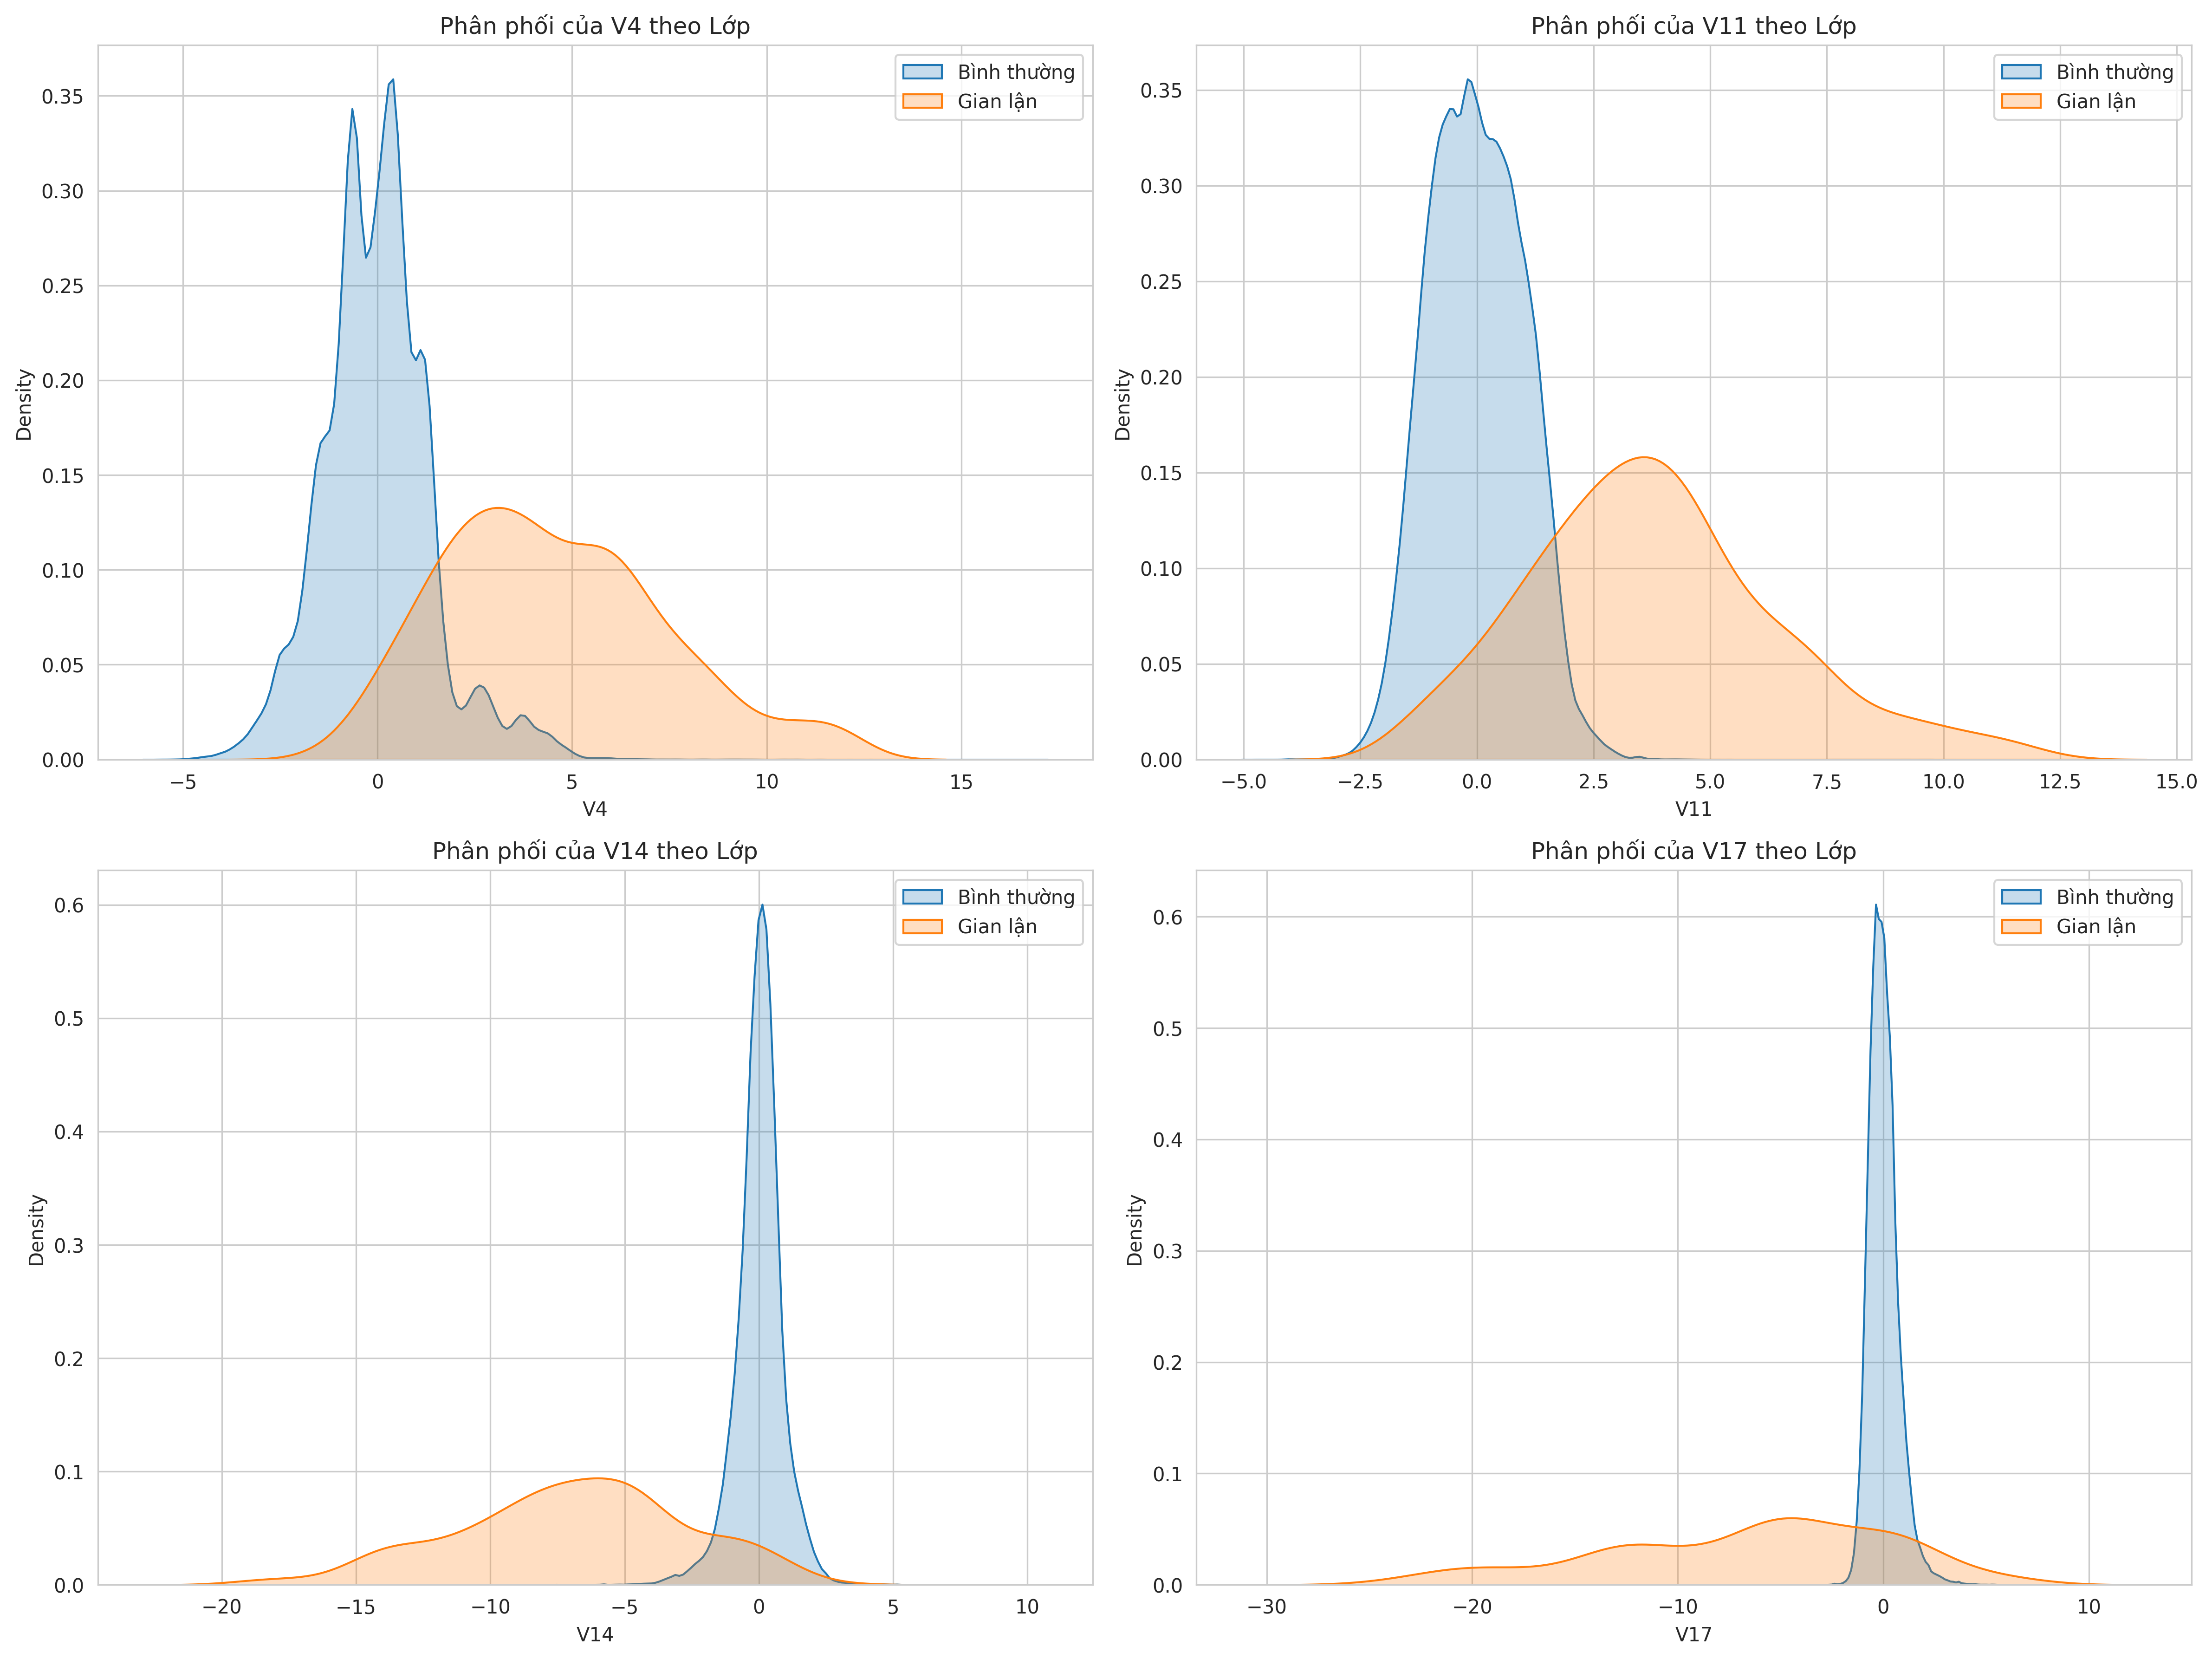

In [9]:
# so sánh phân phối của các biến PCA giữa 2 lớp
# liệu có biến PCA nào giúp phân biệt rõ ràng giữa giao dịch bình thường và gian lận?

# chọn một vài biến để kiểm tra
features_to_plot = ['V4', 'V11', 'V14', 'V17']
plt.figure(figsize=(16, 12))

for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i + 1)
    sns.kdeplot(df[df['Class'] == 0][feature], label='Bình thường', fill=True)
    sns.kdeplot(df[df['Class'] == 1][feature], label='Gian lận', fill=True)
    plt.title(f'Phân phối của {feature} theo Lớp')
    plt.legend()

plt.tight_layout()
plt.show()

> **Nhận xét:**
> - Rõ ràng có sự khác biệt trong phân phối của một số biến PCA giữa hai lớp.
> - Ví dụ, với `V14` và `V17`, phân phối của các giao dịch gian lận (màu cam) có đỉnh nhọn và lệch hẳn so với phân phối của các giao dịch bình thường.
> - **Ý nghĩa:** Điều này khẳng định rằng các biến PCA này chứa **thông tin rất giá trị** để phân biệt gian lận. Các mô hình máy học sẽ có thể khai thác những khác biệt này để thực hiện việc phân loại.


**TỔNG KẾT KHÁM PHÁ DỮ LIỆU**
> - **Dữ liệu cực kỳ mất cân bằng:** Đây là đặc điểm định hình toàn bộ bài toán. Cần các kỹ thuật xử lý đặc biệt (ví dụ: Undersampling, Oversampling như SMOTE) và các thước đo phù hợp (Precision, Recall, F1, AUC-PR).
> - **Dữ liệu đã được làm sạch:** Không có giá trị thiếu, giúp tiết kiệm thời gian tiền xử lý.
> - **Cần chuẩn hóa 'Amount' và 'Time':** Hai biến này có thang đo và phân phối khác biệt hoàn toàn so với các biến PCA, do đó cần được chuẩn hóa.
> - **Các biến PCA chứa thông tin quan trọng:** Chúng không tương quan với nhau và có phân phối khác biệt rõ rệt giữa hai lớp, là nguồn đặc trưng chính cho mô hình.


### xử lý dữ liệu

#### chuẩn hoá dữ liệu

In [10]:
# chuẩn hóa 'Amount' và 'Time' như đã xác định trong EDA
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df = df.drop(['Time', 'Amount'], axis=1)

#### chia dữ liệu của chúng ta thành tập huấn luyện (train) và tập kiểm tra (test):


In [11]:
X: np.ndarray = df.drop('Class', axis=1).values
y: np.ndarray = df['Class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, 
    stratify=y, # đảm bảo tỷ lệ lớp được giữ nguyên trong tập train/test
)

# chỉ giữ lại các giao dịch bình thường (Class=0) cho việc huấn luyện
X_train_normal: np.ndarray = X_train[y_train == 0]

# chuyển đổi dữ liệu sang torch tensor
train_tensor = torch.from_numpy(X_train_normal).float()
test_tensor = torch.from_numpy(X_test).float()

print(f"số lượng giao dịch trong tập huấn luyện (chỉ gồm giao dịch bình thường): {train_tensor.shape[0]}")
print(f"số lượng giao dịch trong tập kiểm tra (gồm cả bình thường và gian lận): {test_tensor.shape[0]}")


số lượng giao dịch trong tập huấn luyện (chỉ gồm giao dịch bình thường): 227451
số lượng giao dịch trong tập kiểm tra (gồm cả bình thường và gian lận): 56962


### mô hình hoá

In [54]:
class Encoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int):
        super().__init__()

        hidden_dim: int = 16

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)
    


class Decoder(nn.Module):
    def __init__(self, latent_dim: int, output_dim: int):
        super().__init__()

        hidden_dim: int = 16

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.decoder(x)
    

class Autoencoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        latent_representation = self.encoder(x)
        reconstructed_x = self.decoder(latent_representation)
        return reconstructed_x
    


In [ ]:
# class Autoencoder(nn.Module):
#     def __init__(self, input_dim: int):
#         super(Autoencoder, self).__init__()
        
#         # Kích thước của các lớp nén dần
#         encoding_dim_1: int = 16
#         encoding_dim_2: int = 8  # Bottleneck - Lớp nén nhất

#         # --- Encoder ---
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, encoding_dim_1),
#             nn.ReLU(),
#             nn.Linear(encoding_dim_1, encoding_dim_2),
#             nn.ReLU()
#         )

#         # --- Decoder ---
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim_2, encoding_dim_1),
#             nn.ReLU(),
#             nn.Linear(encoding_dim_1, input_dim),
#             nn.Sigmoid() # Sigmoid để đảm bảo đầu ra nằm trong khoảng (0, 1)
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return decoded

In [55]:
# khởi tạo Mô hình, loss function và optimizer
INPUT_DIM: int = train_tensor.shape[1]
LATENT_DIM: int = 8

model: Autoencoder = Autoencoder(input_dim=INPUT_DIM, latent_dim=LATENT_DIM)
criterion = nn.MSELoss() # Dùng Mean Squared Error để đo sai số tái tạo
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [56]:
# huấn luyện mô hình
print("\n--- Bắt đầu huấn luyện mô hình ---")
num_epochs: int = 30
batch_size: int = 256

# DataLoader giúp quản lý việc tạo các batch dữ liệu một cách hiệu quả
train_loader = DataLoader(dataset=train_tensor, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for data in train_loader:
        # Lấy đầu ra từ mô hình
        reconstructed = model(data)
        # Tính loss
        loss = criterion(reconstructed, data)
        # Lan truyền ngược và tối ưu hóa
        optimizer.zero_grad() # Reset gradient về 0
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')


--- Bắt đầu huấn luyện mô hình ---
Epoch [5/30], Loss: 1.067485
Epoch [10/30], Loss: 0.688740
Epoch [15/30], Loss: 0.673498
Epoch [20/30], Loss: 0.650072
Epoch [25/30], Loss: 0.720915
Epoch [30/30], Loss: 0.537691


In [57]:
# đánh giá và Phát hiện Bất thường ---
print("\n--- Bắt đầu đánh giá mô hình ---")
model.eval() # Chuyển mô hình sang chế độ đánh giá (quan trọng!)
with torch.no_grad(): # Tắt tính toán gradient để tăng tốc
    predictions = model(test_tensor)
    # Tính MSE cho từng mẫu trong tập test
    mse = nn.functional.mse_loss(predictions, test_tensor, reduction='none').mean(axis=1).numpy()

error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df


--- Bắt đầu đánh giá mô hình ---


,reconstruction_error,true_class
0,0.330229,0
1,1.823552,0
2,2.792400,0
3,0.207043,0
4,1.002368,0
...,...,...
56957,0.652890,0
56958,0.307500,0
56959,0.771721,0
56960,0.349213,0


In [58]:
def find_optimal_threshold(precision: np.ndarray, recall: np.ndarray, thresholds: np.ndarray) -> float:
    """
    tìm ngưỡng tốt nhất dựa trên đường cong Precision-Recall bằng cách tối đa hóa F1-score.
    """
    # xử lý trường hợp chia cho 0
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_f1_idx = np.argmax(f1_scores)
    return thresholds[best_f1_idx]

In [59]:
precision, recall, thresholds = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
best_threshold = find_optimal_threshold(precision, recall, thresholds)
print(f"\nngưỡng sai số tái tạo tối ưu được tìm thấy là: {best_threshold:.6f}")



ngưỡng sai số tái tạo tối ưu được tìm thấy là: 58.545536


In [60]:
# --- Phân loại dựa trên ngưỡng ---
y_pred = [1 if e > best_threshold else 0 for e in error_df.reconstruction_error.values]

print("\n--- Báo cáo hiệu suất mô hình ---")
print("\nBáo cáo phân loại (Classification Report):")
print(classification_report(y_test, y_pred, target_names=['Bình thường (0)', 'Gian lận (1)']))


--- Báo cáo hiệu suất mô hình ---

Báo cáo phân loại (Classification Report):
                 precision    recall  f1-score   support

Bình thường (0)       1.00      1.00      1.00     56864
   Gian lận (1)       0.48      0.23      0.32        98

       accuracy                           1.00     56962
      macro avg       0.74      0.62      0.66     56962
   weighted avg       1.00      1.00      1.00     56962



Ma trận nhầm lẫn (Confusion Matrix):


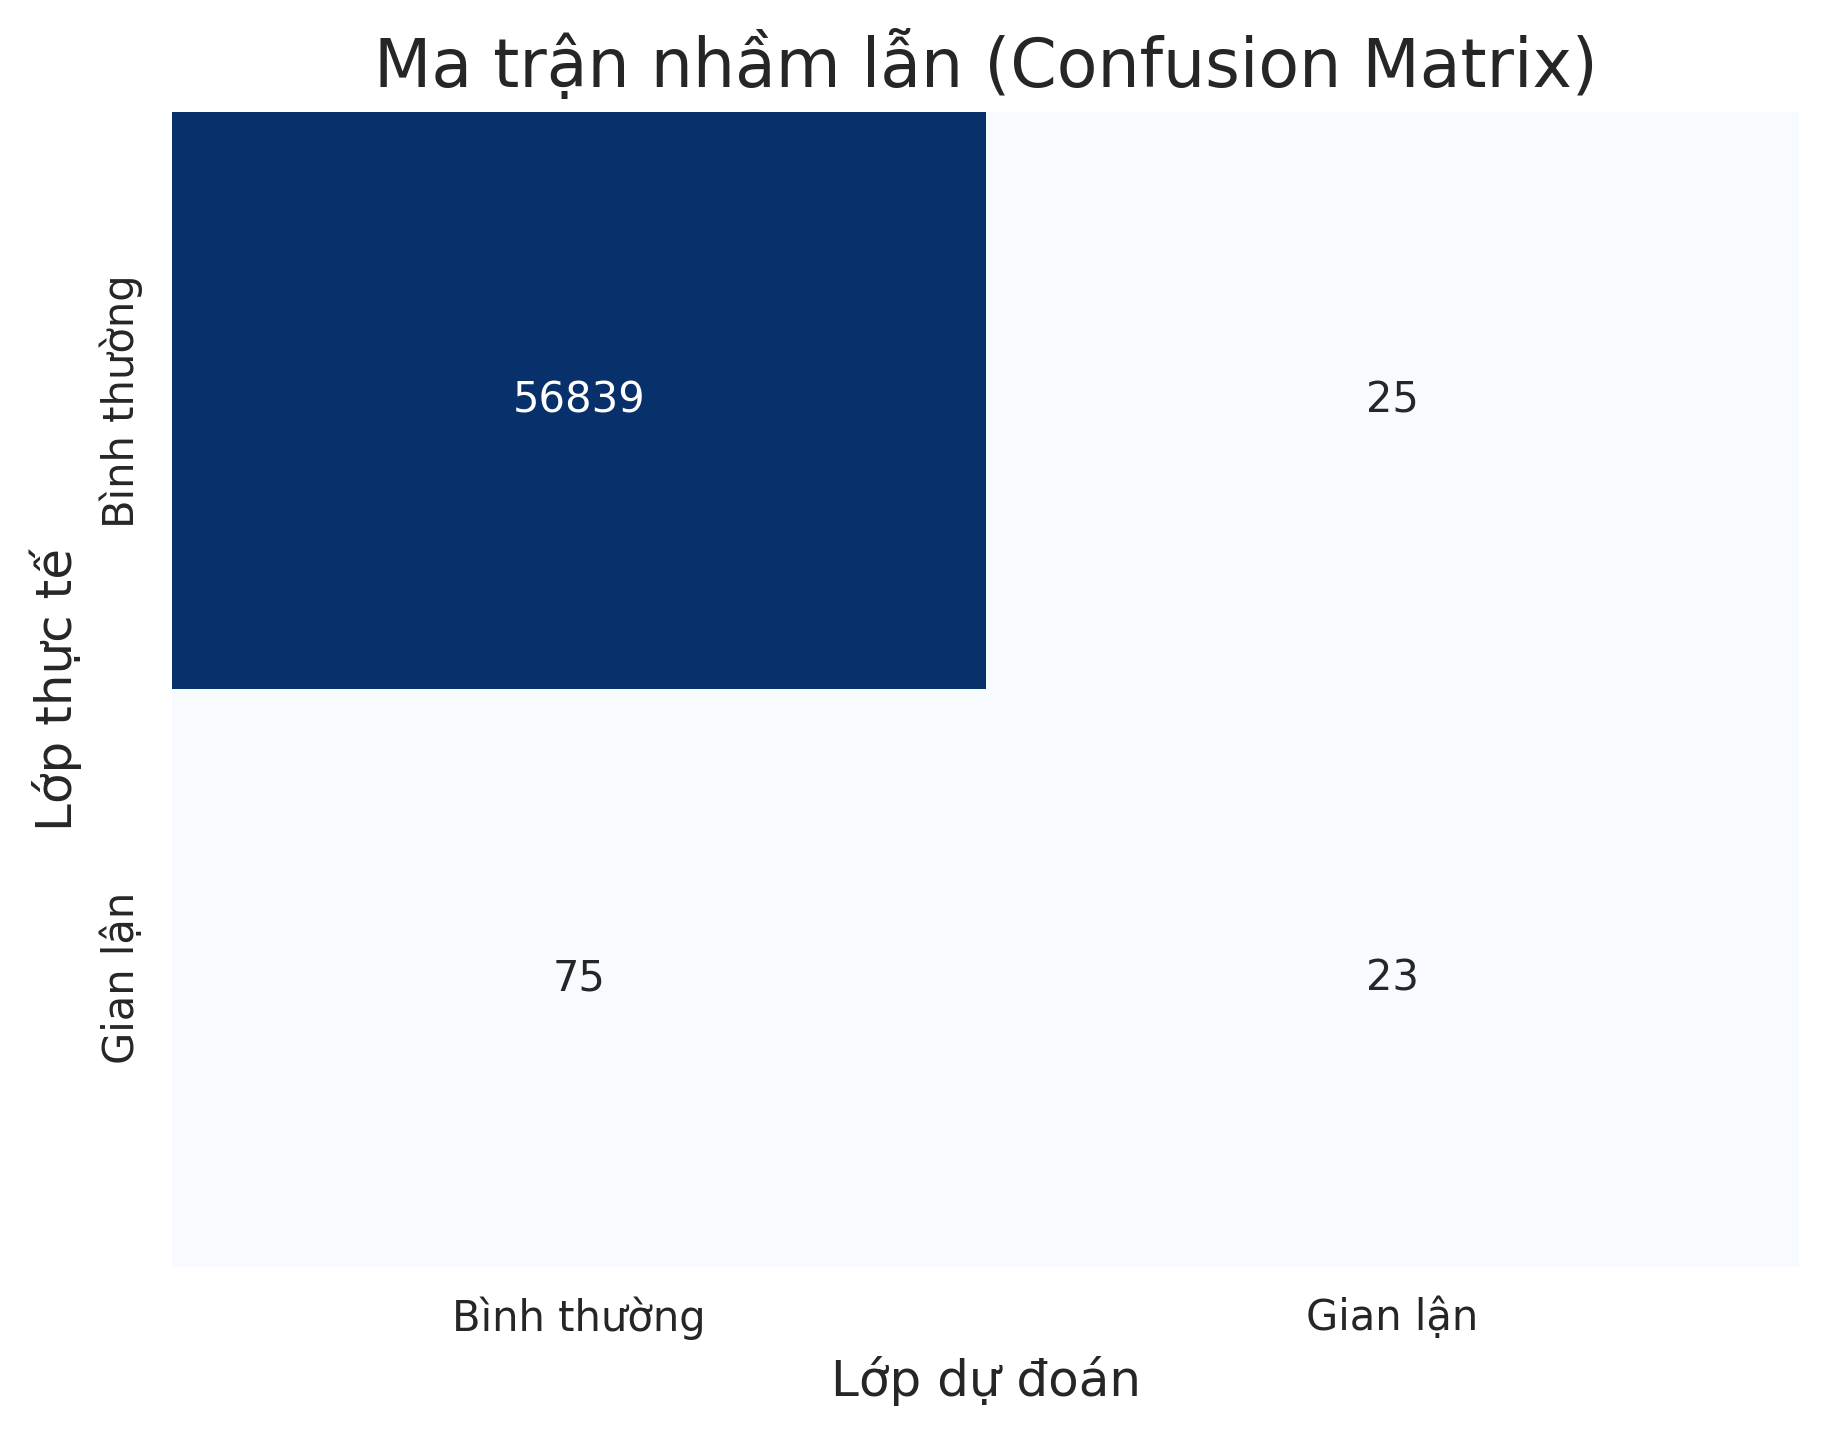

In [61]:
print("Ma trận nhầm lẫn (Confusion Matrix):")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Bình thường', 'Gian lận'],
            yticklabels=['Bình thường', 'Gian lận'])
plt.title("Ma trận nhầm lẫn (Confusion Matrix)", fontsize=16)
plt.ylabel('Lớp thực tế', fontsize=12)
plt.xlabel('Lớp dự đoán', fontsize=12)
plt.show()

**Nhận xét**

Đối với dự đoán "gian lận (1)":

- Precision (Độ chính xác): 0.48 (hay 48%)
    * Trong tất các giao dịch mà mô hình dự đoán là gian lận, có 48% trong số đó thực sự là gian lận.
    * Điều này có nghĩa là mô hình tạo ra khá nhiều báo động giả (false positives) - tức là nó gắn cờ nhầm nhiều giao dịch bình thường là gian lận.
- Recall (Độ phủ / Tỷ lệ phát hiện): 0.23 (hay 23%)
    * Trong tất cả các giao dịch gian lận thực tế đã xảy ra, mô hình chỉ phát hiện thành công 23% trong số đó.
- F1-score: 0.32
    * Đây là trung bình điều hòa của Precision và Recall. Nó là một chỉ số tổng hợp để đo lường hiệu suất.
    * F1-score thấp là do Precision thấp. Điều này cho thấy có sự đánh đổi rõ rệt: để đạt được Recall cao (bắt được nhiều gian lận), chúng ta phải chấp nhận Precision thấp (nhiều báo động giả hơn).
